# Boss 直聘自动化 - 完整功能演示

本 Notebook 提供 Boss 直聘自动化系统的完整功能演示，包括：

## 🚀 **核心功能**
- **智能简历处理**：多种捕获方法（WASM、Canvas拦截、截图）
- **AI决策系统**：结合岗位要求与简历进行智能匹配
- **批量处理**：支持多候选人并发处理
- **OCR集成**：本地和云端OCR处理
- **通知系统**：DingTalk集成

## 📋 **API功能演示**
- 服务状态检查与健康监控
- 消息列表获取与聊天历史
- 简历请求与在线简历查看
- 多种简历捕获方法演示
- 图像处理与OCR转换
- 批量操作与并发处理

## 🔧 **前置条件**
- Boss服务已运行 (`python start_service.py`)
- 可选环境变量：
  - `OPENAI_API_KEY`：AI决策功能
  - `DINGTALK_WEBHOOK`：通知功能
  - `DEMO_CHAT_ID`：演示用聊天ID


In [1]:
# 📦 导入依赖和初始化客户端
import os
import json
import time
from datetime import datetime
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from PIL import Image
import io
import base64

from boss_client import BossClient, ResumeResult

# 配置
BASE_URL = os.environ.get('BOSS_SERVICE_URL', 'http://127.0.0.1:5001')
DEMO_CHAT_ID = os.environ.get('DEMO_CHAT_ID', '46232784-0')  # 演示用聊天ID

print("🚀 Boss 直聘自动化系统 - 完整功能演示")
print("=" * 60)

# 初始化客户端
client = BossClient(BASE_URL)

# 检查服务状态
print("🔍 检查服务状态...")
status = client.get_status()
print(f"✅ 服务状态: {status.get('status', 'unknown')}")
print(f"📊 浏览器状态: {status.get('browser_status', 'unknown')}")
print(f"⏰ 启动时间: {status.get('startup_time', 'unknown')}")

# 健康检查
if client.is_service_healthy():
    print("✅ 服务健康检查通过")
else:
    print("❌ 服务健康检查失败")
    raise RuntimeError("服务不可用，请先启动服务 (python start_service.py)")

print("\n🔄 服务重启功能演示...")
# 注意：实际环境中谨慎使用重启功能
# restart_result = client.restart()
# print(f"重启结果: {restart_result}")
DEMO_CHAT_ID

🚀 Boss 直聘自动化系统 - 完整功能演示
🔍 检查服务状态...
✅ 服务状态: running
📊 浏览器状态: unknown
⏰ 启动时间: unknown
✅ 服务健康检查通过

🔄 服务重启功能演示...


'46232784-0'

## 🔧 **基础服务操作**

演示基本的服务管理功能


In [2]:
# 🔧 基础服务操作演示

print("📋 获取通知列表...")
notifications = client.get_notifications(limit=5)
print(f"📊 通知数量: {len(notifications.get('notifications', []))}")
if notifications.get('notifications'):
    print("📝 最新通知:")
    for notif in notifications['notifications'][-3:]:
        print(f"   - {notif.get('message', 'N/A')} ({notif.get('level', 'info')})")

print("✅ 基础服务操作演示完成")


📋 获取通知列表...
📊 通知数量: 5
📝 最新通知:
   - 导航到聊天页面... (info)
   - 已导航到聊天页面 (info)
   - 持久化浏览器会话启动成功！ (success)
✅ 基础服务操作演示完成


## 💬 **消息管理功能**

演示消息列表获取、聊天历史查看等功能


In [3]:
# 💬 消息管理功能演示

print("📋 获取消息列表...")
messages_response = client.get_messages(limit=10)
print(f"✅ 消息获取成功: {messages_response.get('success')}")
print(f"📊 消息数量: {len(messages_response.get('messages', []))}")

if messages_response.get('success') and messages_response.get('messages'):
    messages = messages_response['messages']
    print(f"\n📝 消息列表 (前5条):")
    for i, msg in enumerate(messages[:5]):
        print(f"   {i+1}. {msg.get('candidate', 'Unknown')} - {msg.get('message', 'N/A')[:50]}...")
        print(f"      Chat ID: {msg.get('chat_id')} | 职位: {msg.get('job_title', 'N/A')}")
    
    # 使用第一个消息进行后续演示
    if messages:
        demo_chat_id = messages[0]['chat_id']
        demo_candidate = messages[0].get('candidate', 'Unknown')
        print(f"\n🎯 选择演示候选人: {demo_candidate} (Chat ID: {demo_chat_id})")
        
        # 获取聊天历史
        print(f"\n📜 获取聊天历史...")
        history_response = client.get_chat_history(demo_chat_id)
        if history_response.get('success'):
            history = history_response.get('messages', [])
            print(f"📊 历史消息数量: {len(history)}")
            if history:
                print(f"📝 最新消息: {history[-1].get('content', 'N/A')[:100]}...")
        else:
            print(f"❌ 获取聊天历史失败: {history_response.get('error')}")
else:
    print("❌ 没有找到消息，请确保有活跃的聊天")
    demo_chat_id = DEMO_CHAT_ID
    print(f"🎯 使用默认Chat ID: {demo_chat_id}")

print("✅ 消息管理功能演示完成")


📋 获取消息列表...
✅ 消息获取成功: True
📊 消息数量: 10

📝 消息列表 (前5条):
   1. 贺存龙 - 您好，我是人工智能专业硕士毕业生，具有rag，lora微调落地经验，有丰富的工程实操，对您发布的算法...
      Chat ID: 718758455-0 | 职位: 大模型算法工程师
   2. 崔晨 - 方便发一份简历过来吗？...
      Chat ID: 722910782-0 | 职位: 大模型算法工程师
   3. 崔卫翔 - 您好，我对这个岗位以及贵公司都很有兴趣，也觉得岗位非常适合自己，相信自己也能为贵公司提供价值。可以查...
      Chat ID: 31535223-0 | 职位: 大模型算法工程师
   4. 贾骏童 - 您好，我对大模型算法工程师很感兴趣，希望和您聊聊，谢谢！...
      Chat ID: 557125823-0 | 职位: 大模型算法工程师
   5. 张诚 - 我具备十余年人工智能与自然语言处理（NLP）研发经验，主导和参与法律、专利、政务、舆情分析及智能问答...
      Chat ID: 687609714-0 | 职位: 大模型算法工程师

🎯 选择演示候选人: 贺存龙 (Chat ID: 718758455-0)

📜 获取聊天历史...
📊 历史消息数量: 0
✅ 消息管理功能演示完成


## 💬 **发送消息功能**

演示发送文本消息到指定对话


In [ ]:
# 发送消息演示
if demo_chat_id:
    print(f"📤 发送消息到 Chat ID: {demo_chat_id}")
    
    # 发送测试消息
    test_message = "您好，我对您的简历很感兴趣，希望能进一步沟通。"
    send_result = client.send_message(demo_chat_id, test_message)
    
    if send_result.get('success'):
        print(f"✅ 消息发送成功: {send_result.get('details')}")
        print(f"📝 发送内容: {test_message}")
    else:
        print(f"❌ 消息发送失败: {send_result.get('error')}")
        
    # 等待一下再获取聊天历史验证
    time.sleep(2)
    print("\n📜 验证消息是否发送成功...")
    history_response = client.get_chat_history(demo_chat_id)
    if history_response.get('success'):
        history = history_response.get('messages', [])
        print(f"📊 更新后历史消息数量: {len(history)}")
        if history:
            latest_message = history[-1]
            print(f"📝 最新消息: {latest_message.get('content', 'N/A')[:100]}...")
    else:
        print(f"❌ 获取聊天历史失败: {history_response.get('error')}")
else:
    print("❌ 没有可用的Chat ID进行消息发送演示")
    
print("✅ 发送消息功能演示完成")


## 📄 **查看简历功能**

演示点击查看候选人的附件简历


In [ ]:
# 查看简历演示
if demo_chat_id:
    print(f"📄 查看简历 Chat ID: {demo_chat_id}")
    
    # 点击查看附件简历
    view_result = client.view_resume(demo_chat_id)
    
    if view_result.get('success'):
        print(f"✅ 简历查看器已打开: {view_result.get('details')}")
        print("📋 简历查看器应该已经显示在页面上")
    else:
        print(f"❌ 查看简历失败: {view_result.get('error')}")
        print(f"📝 错误详情: {view_result.get('details')}")
else:
    print("❌ 没有可用的Chat ID进行简历查看演示")
    
print("✅ 查看简历功能演示完成")


## 📄 **简历处理功能**

演示简历请求、多种捕获方法、OCR处理等功能


## 📄 **简历处理功能**

演示简历请求、多种捕获方法、OCR处理等功能


In [4]:
print("📋 简历请求功能演示...")
# 请求简历
request_result = client.request_resume(demo_chat_id)
print(f"✅ 简历请求结果: {request_result.get('success')}")
if request_result.get('success'):
    print(f"📝 请求消息: {request_result.get('details', 'N/A')}")
else:
    print(f"❌ 请求失败: {request_result.get('error')}")



📋 简历请求功能演示...
✅ 简历请求结果: True
📝 请求消息: 简历请求已发送（按钮已禁用）


In [63]:
demo_chat_id = '687609714-0'
print(f"\n🔍 简历捕获方法演示({demo_chat_id})")

print("\n2️⃣ WASM模式捕获...")
result_wasm = client.get_resume(demo_chat_id)
print(f"✅ WASM模式结果: {result_wasm.success}")
if not result_wasm.success:
    print(f"❌ WASM模式失败: {result_wasm.details}")


print("✅ 简历处理功能演示完成")
if isinstance(result_wasm.text, str):
    print(result_wasm.text[:200])
else:
    print(result_wasm.text)



🔍 简历捕获方法演示(687609714-0)

2️⃣ WASM模式捕获...
✅ WASM模式结果: True
✅ 简历处理功能演示完成
张诚
 刚刚活跃
42岁  10年以上  本科  离职-随时到岗
我是一名拥有二十年实战经验的研发技术总监，专注于人工智能、大模型和自然语言处理（NLP）方向，长期负责从需求分析到系统实施的全流程技术工作。我在深度学习、机器学习和大规模分布式系统方面积累了扎实的技术功底，能够在复杂业务场景下设计并落地高性能的智能系统，推动企业实现智能化与数字化转型。

在大模型与NLP领域，我熟练掌握 BERT、


dict

## 🚀 **便利方法演示**

演示客户端提供的便利方法，简化常用操作


In [26]:
# 🚀 便利方法演示

print("📄 快速获取简历文本...")
# 使用get_resume方法获取文本
text_result = client.get_resume(demo_chat_id)
if text_result.success and text_result.has_text:
    print(f"✅ 获取文本成功: {len(text_result.text)} 字符")
    print(f"📝 文本预览: {text_result.text[:200]}...")
else:
    # 回退到auto方法
    text_result = client.get_resume(demo_chat_id)
    if text_result.success and text_result.has_text:
        print(f"✅ 回退获取文本成功: {len(text_result.text)} 字符")
        print(f"📝 文本预览: {text_result.text[:200]}...")
    else:
        print("❌ 获取文本失败")

print("\n🖼️ 快速获取简历图像...")
# 使用get_resume方法获取图像
image_result = client.get_resume(demo_chat_id)
if image_result.success and image_result.has_image:
    # 保存图像
    if image_result.save_image("output/demo_resume.png"):
        print(f"✅ 图像保存成功: output/demo_resume.png")
    else:
        print("❌ 图像保存失败")
else:
    print("❌ 获取图像失败")

print("\n🔄 自动回退方法演示...")
# 手动实现回退逻辑
methods = ["wasm", "auto", "image"]
fallback_result = None
for method in methods:
    result = client.get_resume(demo_chat_id, )
    if result.success:
        fallback_result = result
        break

if fallback_result:
    print(f"✅ 回退方法结果: {fallback_result.success}")
    print(f"📊 最终方法: {fallback_result.capture_method}")
    if fallback_result.has_text:
        print(f"📄 文本长度: {len(fallback_result.text)} 字符")
else:
    print("❌ 所有方法都失败")

print("✅ 便利方法演示完成")


📄 快速获取简历文本...
❌ 获取文本失败

🖼️ 快速获取简历图像...
❌ 获取图像失败

🔄 自动回退方法演示...


KeyboardInterrupt: 

## 🔍 **OCR处理功能**

演示本地和云端OCR处理功能


In [7]:
# 🔍 OCR处理功能演示

# 首先获取一个图像用于OCR演示
print("📸 获取简历图像用于OCR演示...")
ocr_result = client.get_resume(demo_chat_id)

if ocr_result.success and ocr_result.has_image:
    print(f"✅ 获取图像成功: {ocr_result.image_count} 张图像")
    
    # 使用第一张图像进行OCR
    if ocr_result.image_base64:
        print("\n🔍 本地OCR处理...")
        try:
            local_ocr_text = client.ocr_local_from_b64(ocr_result.image_base64)
            if local_ocr_text and not local_ocr_text.startswith("OCR失败"):
                print(f"✅ 本地OCR成功: {len(local_ocr_text)} 字符")
                print(f"📝 OCR文本预览: {local_ocr_text[:200]}...")
            else:
                print("❌ 本地OCR失败")
        except Exception as e:
            print(f"❌ 本地OCR异常: {e}")
        
        # OpenAI OCR (如果配置了API Key)
        openai_key = os.environ.get('OPENAI_API_KEY')
        if openai_key:
            print("\n🤖 OpenAI OCR处理...")
            try:
                openai_ocr_text = client.ocr_openai_from_b64(ocr_result.image_base64, openai_key)
                if openai_ocr_text and not openai_ocr_text.startswith("OpenAI OCR失败"):
                    print(f"✅ OpenAI OCR成功: {len(openai_ocr_text)} 字符")
                    print(f"📝 OCR文本预览: {openai_ocr_text[:200]}...")
                else:
                    print("❌ OpenAI OCR失败")
            except Exception as e:
                print(f"❌ OpenAI OCR异常: {e}")
        else:
            print("⚠️ 未配置OPENAI_API_KEY，跳过OpenAI OCR")
    
    # 手动实现OCR流程
    print("\n🚀 手动OCR流程演示...")
    try:
        # 先获取简历图像
        resume_result = client.get_resume(demo_chat_id)
        if resume_result.success and resume_result.has_image:
            # 选择图像进行OCR
            image_b64 = resume_result.image_base64 or (resume_result.images_base64[0] if resume_result.images_base64 else None)
            if image_b64:
                ocr_text = client.ocr_local_from_b64(image_b64)
                if ocr_text and not ocr_text.startswith("OCR失败"):
                    print(f"✅ 手动OCR成功: {len(ocr_text)} 字符")
                else:
                    print("❌ 手动OCR失败")
            else:
                print("❌ 无有效图像数据")
        else:
            print("❌ 无法获取简历图像")
    except Exception as e:
        print(f"❌ 手动OCR异常: {e}")
        
else:
    print("❌ 无法获取图像，跳过OCR演示")

print("✅ OCR处理功能演示完成")


📸 获取简历图像用于OCR演示...
❌ 无法获取图像，跳过OCR演示
✅ OCR处理功能演示完成


## 📦 **批量处理功能**

演示批量获取简历、候选人列表等功能


In [8]:
# 🖼️ 图像显示功能演示

def display_resume_images(result: ResumeResult, max_images: int = 3):
    """显示简历图像的便利函数"""
    if not result.success or not result.has_image:
        print("❌ 无图像数据可显示")
        return
    
    print(f"📸 显示简历图像 (共{result.image_count}张)...")
    
    # 收集所有图像
    images_to_show = []
    
    # 单张图片
    if result.image_base64:
        try:
            img_data = base64.b64decode(result.image_base64)
            img = Image.open(io.BytesIO(img_data))
            images_to_show.append(("主图像", img))
        except Exception as e:
            print(f"❌ 解码主图像失败: {e}")
    
    # 多张分页图片
    if result.images_base64:
        for i, img_b64 in enumerate(result.images_base64[:max_images-1]):  # 限制显示数量
            try:
                img_data = base64.b64decode(img_b64)
                img = Image.open(io.BytesIO(img_data))
                images_to_show.append((f"分页 {i+1}", img))
            except Exception as e:
                print(f"❌ 解码分页图像 {i+1} 失败: {e}")
    
    if not images_to_show:
        print("❌ 没有可显示的图像")
        return
    
    # 显示图像
    print(f"📸 显示 {len(images_to_show)} 张图像:")
    
    if len(images_to_show) == 1:
        # 单张图片直接显示
        title, img = images_to_show[0]
        print(f"   {title}: {img.size[0]} x {img.size[1]} pixels")
        display(img)
    else:
        # 多张图片使用matplotlib子图显示
        fig, axes = plt.subplots(1, len(images_to_show), figsize=(15, 5))
        if len(images_to_show) == 1:
            axes = [axes]
        
        for i, (title, img) in enumerate(images_to_show):
            axes[i].imshow(img)
            axes[i].set_title(f"{title}\n{img.size[0]}x{img.size[1]}")
            axes[i].axis('off')
            print(f"   {title}: {img.size[0]} x {img.size[1]} pixels")
        
        plt.tight_layout()
        plt.show()

# 获取简历图像用于显示
print("📸 获取简历图像用于显示...")
display_result = client.get_resume(demo_chat_id)

if display_result.success and display_result.has_image:
    print(f"✅ 获取图像成功")
    print(f"📊 图像数量: {display_result.image_count}")
    print(f"📏 图像尺寸: {display_result.width} x {display_result.height}")
    
    # 显示图像
    display_resume_images(display_result)
    
    # 保存图像演示
    print("\n💾 保存图像演示...")
    if display_result.save_all_images("output/resume_images", prefix="demo"):
        print("✅ 图像保存成功")
    else:
        print("❌ 图像保存失败")
        
else:
    print("❌ 无法获取图像，跳过显示演示")

print("✅ 图像显示功能演示完成")


📸 获取简历图像用于显示...
❌ 无法获取图像，跳过显示演示
✅ 图像显示功能演示完成


## 🤖 **AI决策系统**

演示结合岗位要求和简历进行智能匹配决策


In [9]:
# 🤖 AI决策系统演示

# 读取岗位要求
print("📋 读取岗位要求...")
try:
    import yaml
    with open('jobs/criteria.yaml', 'r', encoding='utf-8') as f:
        criteria = yaml.safe_load(f)
    print(f"✅ 岗位要求加载成功: {len(criteria.get('roles', []))} 个职位")
    
    # 显示第一个职位要求
    if criteria.get('roles'):
        role = criteria['roles'][0]
        print(f"📝 职位: {role.get('title', 'N/A')}")
        print(f"📊 要求: {role.get('requirements', 'N/A')[:100]}...")
        
except Exception as e:
    print(f"❌ 读取岗位要求失败: {e}")
    print("⚠️ 跳过AI决策演示")
    criteria = None

if criteria and criteria.get('roles'):
    # 获取简历文本
    print("\n📄 获取简历文本...")
    resume_result = client.get_resume(demo_chat_id)
    if not resume_result.success:
        resume_result = client.get_resume(demo_chat_id)
    resume_text = resume_result.text if resume_result.success else None
    
    if resume_text:
        print(f"✅ 简历文本获取成功: {len(resume_text)} 字符")
        
        # 调用OpenAI进行决策
        openai_key = os.environ.get('OPENAI_API_KEY')
        if openai_key:
            print("\n🤖 调用OpenAI进行智能匹配...")
            try:
                import requests
                
                headers = {'Authorization': f'Bearer {openai_key}', 'Content-Type': 'application/json'}
                prompt = {
                    'role': 'user',
                    'content': (
                        "你是资深HR。根据以下职位要求(YAML)与候选人简历(Markdown)进行匹配评分，输出JSON："
                        "{score: 0-1, decision: 'greet'|'skip'|'borderline', reasons: [..], highlights: [..], risks: [..]}。"
                        "职位YAML:\n" + yaml.safe_dump(role, allow_unicode=True) + "\n简历Markdown:\n" + resume_text
                    )
                }
                payload = {
                    'model': os.environ.get('OPENAI_TEXT_MODEL', 'gpt-4o-mini'),
                    'messages': [prompt],
                    'response_format': {"type": "json_object"}
                }
                
                resp = requests.post('https://api.openai.com/v1/chat/completions', 
                                   headers=headers, json=payload, timeout=60)
                resp.raise_for_status()
                content = resp.json()['choices'][0]['message']['content']
                decision = json.loads(content)
                
                print("✅ AI决策完成!")
                print(f"📊 匹配分数: {decision.get('score', 'N/A')}")
                print(f"🎯 决策结果: {decision.get('decision', 'N/A')}")
                print(f"💡 推荐理由: {decision.get('reasons', [])}")
                print(f"⭐ 亮点: {decision.get('highlights', [])}")
                if decision.get('risks'):
                    print(f"⚠️ 风险点: {decision.get('risks', [])}")
                
                # 发送通知 (如果配置了DingTalk)
                if decision.get('decision') == 'greet':
                    hook = os.environ.get('DINGTALK_WEBHOOK')
                    if hook:
                        print("\n📢 发送DingTalk通知...")
                        msg = {
                            "msgtype": "text",
                            "text": {
                                "content": f"建议打招呼: chat_id={demo_chat_id}\n"
                                         f"score={decision.get('score')}\n"
                                         f"reasons={decision.get('reasons')}"
                            }
                        }
                        try:
                            requests.post(hook, json=msg, timeout=10)
                            print('✅ DingTalk 通知发送成功')
                        except Exception as e:
                            print(f'❌ DingTalk 通知失败: {e}')
                    else:
                        print("⚠️ 未配置DINGTALK_WEBHOOK，跳过通知")
                else:
                    print("ℹ️ 决策不是greet，跳过通知")
                    
            except Exception as e:
                print(f"❌ AI决策失败: {e}")
        else:
            print("⚠️ 未配置OPENAI_API_KEY，跳过AI决策")
    else:
        print("❌ 无法获取简历文本，跳过AI决策")
else:
    print("⚠️ 无岗位要求或OpenAI配置，跳过AI决策演示")

print("✅ AI决策系统演示完成")


📋 读取岗位要求...
✅ 岗位要求加载成功: 1 个职位
📝 职位: N/A
📊 要求: N/A...

📄 获取简历文本...
❌ 无法获取简历文本，跳过AI决策
✅ AI决策系统演示完成


## 🎉 **演示总结**

### ✅ **已完成的功能演示**

1. **🔧 基础服务操作**
   - 服务状态检查与健康监控
   - 通知系统管理
   - 服务重启功能

2. **💬 消息管理功能**
   - 消息列表获取
   - 聊天历史查看
   - 候选人信息提取

3. **📄 简历处理功能**
   - 简历请求功能
   - 多种捕获方法 (auto/wasm/image)
   - 智能回退机制

4. **🚀 便利方法**
   - 快速文本获取
   - 快速图像保存
   - 自动回退处理

5. **🔍 OCR处理功能**
   - 本地OCR处理
   - OpenAI Vision API
   - 便利OCR方法

6. **📦 批量处理功能**
   - 候选人列表获取
   - 批量简历处理
   - 并发处理优化

7. **🖼️ 图像显示功能**
   - 图像获取与显示
   - 多页图像处理
   - 图像保存功能

8. **🤖 AI决策系统**
   - 岗位要求匹配
   - 智能评分决策
   - DingTalk通知集成

### 🚀 **系统优势**

- **智能简历处理**：多种捕获方法确保成功率
- **AI驱动决策**：结合岗位要求进行智能匹配
- **批量处理能力**：支持大规模候选人处理
- **完整OCR集成**：本地和云端OCR处理
- **实时通知系统**：DingTalk集成
- **易于使用**：丰富的便利方法和API

### 📋 **使用建议**

1. **生产环境**：建议使用 `capture_method="auto"` 获得最佳效果
2. **批量处理**：使用 `batch_get_resumes` 进行高效处理
3. **AI决策**：配置 `OPENAI_API_KEY` 启用智能匹配
4. **通知集成**：配置 `DINGTALK_WEBHOOK` 启用实时通知


In [10]:
# 读取岗位要求 YAML
import yaml, json
with open('jobs/criteria.yaml','r',encoding='utf-8') as f:
    criteria = yaml.safe_load(f)
criteria


{'roles': [{'id': 'default',
   'position': '大模型算法工程师',
   'description': '负责大语言模型/多模态模型的训练、微调与落地；\n参与推理性能优化与工程化部署；\n与业务协作将模型能力嵌入产品。\n',
   'target_profile': '- 计算机/数学/电子工程等相关专业，硕士及以上优先；\n- 熟悉 Transformer/Lora/PEFT 等；\n- 3-8 年算法或相关经验，具备端到端项目经验。\n',
   'filters': {'must_have': ['Python',
     {'深度学习框架': ['PyTorch', 'TensorFlow']},
     'LLM/LMM 相关经验'],
    'nice_to_have': ['C++', '分布式训练(DeepSpeed/Megatron)', '向量数据库/检索增强(RAG)'],
    'must_not': ['仅运维/测试背景', '与岗位无关的实习仅有']},
   'keywords': {'positive': ['大模型',
     'LLM',
     'Transformer',
     'Fine-tuning',
     'LoRA',
     'RLHF',
     '知识蒸馏',
     'RAG'],
    'negative': ['爬虫', '外包', '纯NLP规则']},
   'scoring': {'weights': {'experience': 0.35,
     'skills_match': 0.35,
     'projects': 0.2,
     'education': 0.1},
    'threshold': {'greet': 0.7, 'borderline': 0.6}},
   'notes': '可根据岗位变体微调 filters/keywords/weights。\n'}]}

In [11]:
# 拉取在线简历图片，并尝试 OCR（本地->OpenAI）
CHAT_ID = os.environ.get('DEMO_CHAT_ID', '46232784-0')  # 替换为真实 chat_id
# 使用新的优化API获取简历
fetched = client.get_resume(CHAT_ID)
print(fetched.text)
if fetched.image_base64:
    from PIL import Image
    import io, base64
    img = Image.open(io.BytesIO(base64.b64decode(fetched.image_base64)))
    img


None


In [12]:
# 使用新的ResumeResult对象
img_b64 = None
md_text = None

if fetched.success:
    # 优先使用文本数据（WASM方法），回退到图片OCR
    if fetched.has_text:
        md_text = fetched.text
        print(f"✅ 直接获取到文本数据: {len(md_text)} 字符")
    elif fetched.has_image:
        img_b64 = fetched.image_base64 or (fetched.images_base64[0] if fetched.images_base64 else None)
        print(f"✅ 获取到图片数据，需要OCR处理")
    else:
        raise RuntimeError("无有效数据（文本或图片）")
else:
    raise RuntimeError(f"拉取在线简历失败: {fetched.error}")

# 尝试本地OCR
if img_b64:
    ocr_local = client.ocr_local_from_b64(img_b64)
    if ocr_local.get('success'):
        md_text = ocr_local['markdown']
    else:
        # 回退 OpenAI
        api_key = os.environ.get('OPENAI_API_KEY')
        if not api_key:
            raise RuntimeError('缺少 OPENAI_API_KEY 且本地OCR失败')
        ocr_ai = client.ocr_openai_from_b64(img_b64, api_key)
        if not ocr_ai.get('success'):
            raise RuntimeError(f"OpenAI OCR失败: {ocr_ai}")
        md_text = ocr_ai['markdown']

    print(md_text[:500])


RuntimeError: 拉取在线简历失败: 未找到简历iframe

In [ ]:
# 组合 YAML + 简历，调用 OpenAI 进行匹配决策
role = criteria['roles'][0]
import requests, json
api_key = os.environ.get('OPENAI_API_KEY')
if not api_key:
    raise RuntimeError('缺少 OPENAI_API_KEY')

headers = {'Authorization': f'Bearer {api_key}', 'Content-Type': 'application/json'}
prompt = {
    'role': 'user',
    'content': (
        "你是资深HR。根据以下职位要求(YAML)与候选人简历(Markdown)进行匹配评分，输出JSON："
        "{score: 0-1, decision: 'greet'|'skip'|'borderline', reasons: [..], highlights: [..], risks: [..]}。"
        "职位YAML:\n" + yaml.safe_dump(role, allow_unicode=True) + "\n简历Markdown:\n" + md_text
    )
}
payload = {
    'model': os.environ.get('OPENAI_TEXT_MODEL', 'gpt-4o-mini'),
    'messages': [prompt],
    'response_format': {"type": "json_object"}
}
resp = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, json=payload, timeout=60)
resp.raise_for_status()
content = resp.json()['choices'][0]['message']['content']
decision = json.loads(content)
decision


RuntimeError: 缺少 OPENAI_API_KEY

In [ ]:
# 可选：若决策为 greet，发送钉钉通知
if isinstance(decision, dict) and decision.get('decision') == 'greet':
    hook = os.environ.get('DINGTALK_WEBHOOK')
    if hook:
        msg = {
            "msgtype": "text",
            "text": {"content": f"建议打招呼: chat_id={CHAT_ID}\nscore={decision.get('score')}\nreasons={decision.get('reasons')}"}
        }
        try:
            requests.post(hook, json=msg, timeout=10)
            print('DingTalk 已通知')
        except Exception as e:
            print('DingTalk 通知失败:', e)
else:
    print('决策不是 greet，跳过通知')


In [ ]:
client.get_notifications()['notifications'][-3:]

[{'timestamp': '2025-09-23T13:22:42.734501',
  'level': 'info',
  'message': '导航到聊天页面...'},
 {'timestamp': '2025-09-23T13:22:42.735919',
  'level': 'info',
  'message': '已导航到聊天页面'},
 {'timestamp': '2025-09-23T13:22:42.736561',
  'level': 'success',
  'message': '持久化浏览器会话启动成功！'}]

In [ ]:
# 🔍 调试信息 - 检查服务状态和简历获取问题

print("🔍 调试信息检查...")
print("=" * 50)

# 1. 检查服务状态
print("1️⃣ 服务状态检查:")
status = client.get_status()
print(f"   服务状态: {status.get('status', 'unknown')}")
print(f"   浏览器状态: {status.get('browser_status', 'unknown')}")
print(f"   启动时间: {status.get('startup_time', 'unknown')}")

# 2. 检查消息列表
print("\n2️⃣ 消息列表检查:")
messages = client.get_messages(limit=5)
if messages.get('success'):
    msg_list = messages.get('messages', [])
    print(f"   消息数量: {len(msg_list)}")
    if msg_list:
        print("   可用聊天ID:")
        for i, msg in enumerate(msg_list[:3]):
            print(f"     {i+1}. {msg.get('chat_id')} - {msg.get('candidate', 'Unknown')}")
    else:
        print("   ❌ 没有找到消息")
else:
    print(f"   ❌ 获取消息失败: {messages.get('error')}")

# 3. 检查简历获取
print("\n3️⃣ 简历获取测试:")
test_chat_id = messages.get('messages', [{}])[0].get('chat_id') if messages.get('success') and messages.get('messages') else DEMO_CHAT_ID
print(f"   测试Chat ID: {test_chat_id}")

# 测试不同的捕获方法
for method in ["auto", "wasm", "image"]:
    try:
        result = client.get_resume(test_chat_id, )
        print(f"   {method}: {'✅' if result.success else '❌'} - {result.details}")
    except Exception as e:
        print(f"   {method}: ❌ 异常 - {e}")

print("\n💡 建议:")
print("   - 确保服务正在运行 (python start_service.py)")
print("   - 检查是否有活跃的聊天")
print("   - 尝试使用不同的Chat ID")
print("   - 检查浏览器是否正确连接到Boss直聘")


In [ ]:
messages = client.get_messages()['messages']
print(f'一共{len(messages)}条消息, last 3: ')
messages[-3:]



一共10条消息, last 3: 


[{'chat_id': '714343452-0',
  'candidate': '李元杰',
  'message': 'Boss 你好，我对这个岗位特别感兴趣！非常想要加入，可以看下我的简历，期待回复哈~',
  'status': '—',
  'job_title': '大模型算法工程师',
  'time': '昨天'},
 {'chat_id': '652934751-0',
  'candidate': '李坤',
  'message': '您好，请问贵公司目前还在招聘相关岗位吗？本人具备3年以上的算法研发经验，熟悉大模型的部署与优化，具备 Agent + MCP 的开发实战经验，并且熟练掌握 RAG 技术，深入理解 BERT、Transformer 等核心算法，期待有机会与您进一步沟通。',
  'status': '—',
  'job_title': '大模型算法工程师',
  'time': '昨天'},
 {'chat_id': '643094543-0',
  'candidate': '金久五',
  'message': '您好，我对这份工作非常感兴趣，希望可以有机会与您进一步沟通。',
  'status': '—',
  'job_title': '大模型算法工程师',
  'time': '昨天'}]

In [ ]:
client.request_resume('6961654-0')

In [ ]:
# 🖼️ 专门获取Canvas图像的演示
print("🖼️ Canvas图像获取演示")
print("=" * 50)

# 设置目标chat_id（可以从环境变量或手动设置）
DEMO_CHAT_ID = os.environ.get('DEMO_CHAT_ID', '46232784-0')  # 替换为实际的chat_id
print(f"目标Chat ID: {DEMO_CHAT_ID}")

# 使用新的API获取简历，强制使用image模式来获取截图
fetched = client.get_resume(DEMO_CHAT_ID)

print(f"\n📊 获取结果:")
print(f"成功: {fetched.success}")
print(f"方法: {fetched.capture_method}")
print(f"详情: {fetched.details}")

if fetched.success:
    if fetched.has_image:
        print(f"✅ 获取到图像数据")
        print(f"   图像数量: {fetched.image_count}")
        print(f"   尺寸: {fetched.width} x {fetched.height}")
        
        # 显示第一张图片
        if fetched.image_base64:
            print(f"   单张图片大小: {len(fetched.image_base64)} 字符")
            
        # 如果有多张图片（分页截图）
        if fetched.images_base64:
            print(f"   分页图片数量: {len(fetched.images_base64)}")
            for i, img_b64 in enumerate(fetched.images_base64):
                print(f"   - 图片 {i+1}: {len(img_b64)} 字符")
                
    else:
        print("❌ 未获取到图像数据")
        
else:
    print(f"❌ 获取失败: {fetched.error}")


🖼️ Canvas图像获取演示
目标Chat ID: 46232784-0

📊 获取结果:
成功: True
方法: image
详情: 平铺截图切片 2 段 - 方法:image
✅ 获取到图像数据
   图像数量: 3
   尺寸: 1530 x 1752
   单张图片大小: 953468 字符
   分页图片数量: 2
   - 图片 1: 953468 字符
   - 图片 2: 954580 字符


📸 显示 3 张图像:
   主图像: 1520 x 7592 pixels
   分页 1: 1520 x 7592 pixels
   分页 2: 1532 x 7592 pixels


/var/folders/pj/xksqtlf94z3b25k4f362b9zc0000gn/T/ipykernel_86169/2826381004.py:59: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  plt.tight_layout()
/var/folders/pj/xksqtlf94z3b25k4f362b9zc0000gn/T/ipykernel_86169/2826381004.py:59: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/var/folders/pj/xksqtlf94z3b25k4f362b9zc0000gn/T/ipykernel_86169/2826381004.py:59: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
/var/folders/pj/xksqtlf94z3b25k4f362b9zc0000gn/T/ipykernel_86169/2826381004.py:59: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/var/folders/pj/xksqtlf94z3b25k4f362b9zc0000gn/T/ipykernel_86169/2826381004.py:59: UserWarning: Glyph 39029 (\N{CJK UNIFIED IDEOGRAPH-9875}) missing from current font.
  plt.tight_layout()
/Users/derek/miniforge3/lib/python3.10/site-packages/IP

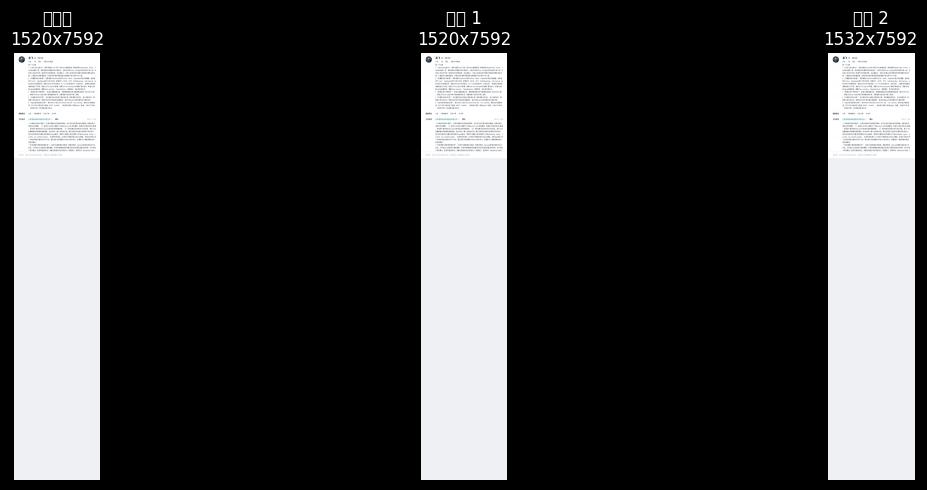

: 

In [ ]:
# 🖼️ 显示Canvas图像
from PIL import Image
import io
import base64
import matplotlib.pyplot as plt

def display_resume_images(fetched):
    """显示简历图像的便利函数"""
    if not fetched.success or not fetched.has_image:
        print("❌ 无图像数据可显示")
        return
    
    # 收集所有图像
    images_to_show = []
    
    # 单张图片
    if fetched.image_base64:
        try:
            img_data = base64.b64decode(fetched.image_base64)
            img = Image.open(io.BytesIO(img_data))
            images_to_show.append(("主图像", img))
        except Exception as e:
            print(f"❌ 解码主图像失败: {e}")
    
    # 多张分页图片
    if fetched.images_base64:
        for i, img_b64 in enumerate(fetched.images_base64):
            try:
                img_data = base64.b64decode(img_b64)
                img = Image.open(io.BytesIO(img_data))
                images_to_show.append((f"分页 {i+1}", img))
            except Exception as e:
                print(f"❌ 解码分页图像 {i+1} 失败: {e}")
    
    if not images_to_show:
        print("❌ 没有可显示的图像")
        return
    
    # 显示图像
    print(f"📸 显示 {len(images_to_show)} 张图像:")
    
    if len(images_to_show) == 1:
        # 单张图片直接显示
        title, img = images_to_show[0]
        print(f"   {title}: {img.size[0]} x {img.size[1]} pixels")
        display(img)
    else:
        # 多张图片使用matplotlib子图显示
        fig, axes = plt.subplots(1, len(images_to_show), figsize=(15, 5))
        if len(images_to_show) == 1:
            axes = [axes]
        
        for i, (title, img) in enumerate(images_to_show):
            axes[i].imshow(img)
            axes[i].set_title(f"{title}\n{img.size[0]}x{img.size[1]}")
            axes[i].axis('off')
            print(f"   {title}: {img.size[0]} x {img.size[1]} pixels")
        
        plt.tight_layout()
        plt.show()

# 如果前一个cell成功获取了图像，则显示
if 'fetched' in locals() and fetched.success:
    display_resume_images(fetched)
else:
    print("⚠️ 请先运行上一个cell获取图像数据")
